# Unidad 9 - Computación III
Carrera Física Aplicada, INSPT UTN<br>
Daiana Dominikow. Septiembre 2024.

# PySerial: análisis espectral, filtrado y reconstruccion de una señal
Supongamos que quiero mezclar lo que aprendimos en la unidad 8 (análisis y  filtrado de señales) con la nueva adquisición de la unidad 9.<br><br>
La idea es que observen que se puede  levantar una señal de la vida real con ruido con un micrófono (MAX9814 es el nombre del sensor en cuestión) con ruido, y hacer el análisis y filtrado correspondiente y devolverla en el mejor estado posible.<br><br>
El ruido agregado a la grabacion es <a href = 'https://youtu.be/x00hLj7dpQc?si=3Sge8tt7GpO06_ml'> esta frecuencia 440 Hz</a>.<br>

In [1]:
import serial #para leer la data del arduino uno
import serial.tools.list_ports as lp
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.io import wavfile # para guardar la señal

plt.rcParams["figure.figsize"] = (18,4)


In [2]:
### para ver en que puerto tengo el sensor en cuestión
ports = list(lp.comports())

for p in ports:
    print(p)

/dev/cu.debug-console - n/a
/dev/cu.WH-CH510 - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbmodem11401 - IOUSBHostDevice


In [10]:
#declaro dos variables, el puerto donde esta conectada la placa y el BAUD

puerto_arduino = '/dev/cu.usbmodem11401' #el puerto 
baud = 115200 #velocidad de comunicación entre la compu y el arduino
try:
    arduino = serial.Serial(port=puerto_arduino, baudrate=baud)  
    print(f'Conectado exitosamente al puerto: {puerto_arduino} BAUD rate: {baud}')
except:
    print(f'No se pudo conectar al puerto: {puerto_arduino} BAUD rate: {baud}')

Conectado exitosamente al puerto: /dev/cu.usbmodem11401 BAUD rate: 115200


Ahora voy a grabar mi voz con el ruido de fondo!

In [ ]:
#inicializamos el array
def save_sensor_data():
    data = arduino.readline().decode('utf-8').strip()
    print(f"Data {time.strftime('%H:%M:%S')}: {data}")
    return data 
t = 5 #supongamos que quiero que corra mi script durante 5 segundos.
datos = np.array([])
t_end = time.time() + t  

while time.time() < t_end:
    data = save_sensor_data()
    datos = np.append(datos, int(data))


#eliminé el output que era larguisimo para que no arruine el notebook en GitHub

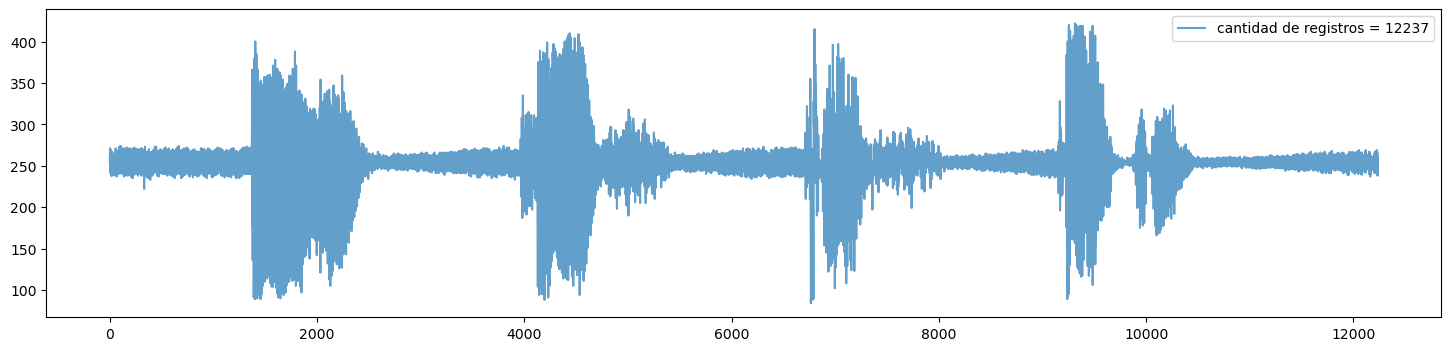

In [12]:
plt.plot(datos, label = f'cantidad de registros = {str(len(datos))}', alpha = 0.7)
plt.legend()
plt.show()

In [13]:
#cierro la conexión con el serial, ya tengo mi muestra
arduino.close()

In [14]:
# recordemos que la frecuencia de muestreo no es muy precisa en el pasaje de arduino a Python 
# por lo que estimaremos en base a la cantidad de datos de nuestro vector y el tiempo que le seteamos de ejecución
periodo = 1.0/ int(len(datos)/t ) 

# hago la transformada rápida de Fourier en el dominio real
datos_fft = np.fft.rfft(datos)

# obtengo el dominio de frecuencias
rfrec=np.fft.rfftfreq(datos.size, d = periodo)

print(len(rfrec))

6119


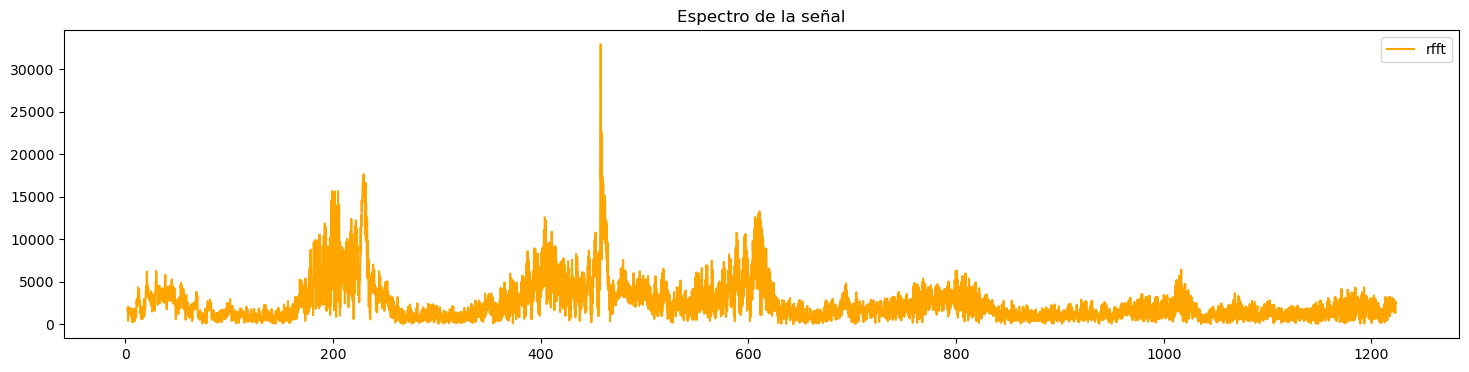

In [15]:
plt.title('Espectro de la señal')
plt.plot(rfrec[10:], np.abs(datos_fft[10:]), color ='orange', label = 'rfft')
plt.legend()
plt.show()

In [16]:
#Guardo mi señal
wavfile.write(filename = "senial_sucia.wav"
              ,rate = int(len(datos)/t )#sample rate, lo saco del vector de datos original sobre el tiempo que corrio el script.
              , data = datos.astype(np.int16))


Ahora le vamos a sacar ese ruidode 400Hz que le mandé de fondo.

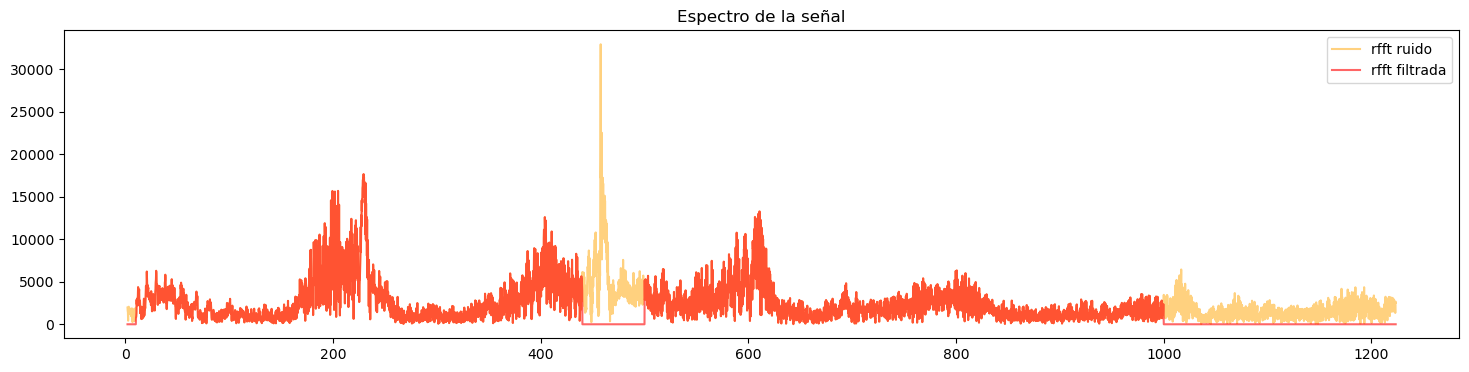

In [27]:
filtro = np.zeros(len(rfrec))

#supongamos quiero filtrar que solo me traiga las frecuencias entre 10 y 1000hz que no esten en el pico del ruido de 440 hz que agregué
for n in range(len(rfrec)):
    if (rfrec[n] > 10 and rfrec[n] < 440)  or (rfrec[n] > 500 and rfrec[n] < 1000):
        filtro[n] = 1

datos_fft_filtrado = datos_fft * filtro

plt.title('Espectro de la señal')
plt.plot(rfrec[10:], np.abs(datos_fft[10:]), color ='orange', label = 'rfft ruido', alpha = 0.5)
plt.plot(rfrec[10:], np.abs(datos_fft_filtrado[10:]), color ='red', label = 'rfft filtrada', alpha = 0.6)

plt.legend()
plt.show()

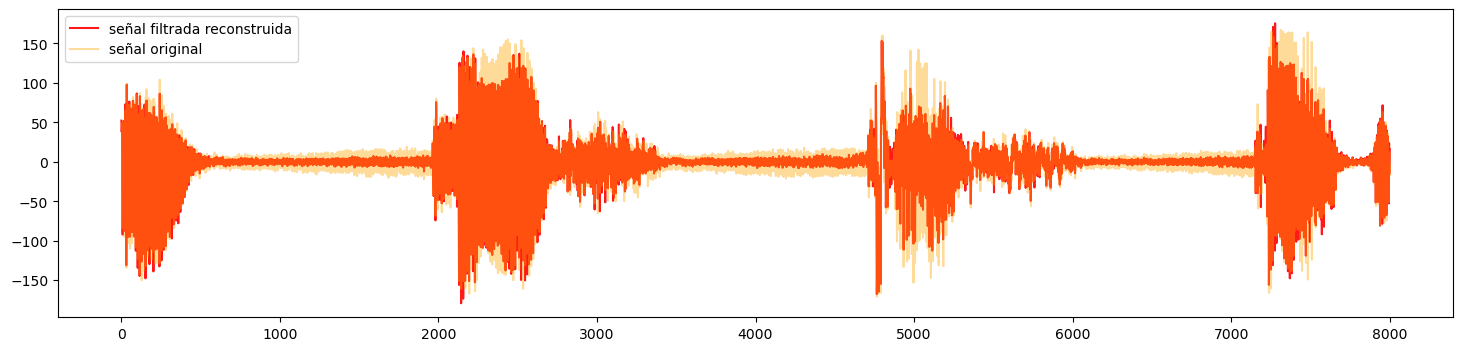

In [28]:
#reconstrucción de la señal
datos_reconstruidos = np.fft.irfft(datos_fft_filtrado)

plt.plot(datos_reconstruidos[2000:10000],label = 'señal filtrada reconstruida' , color = 'red', alpha = 0.9)
plt.plot(datos[2000:10000]-255,label = 'señal original' , color = 'orange', alpha = 0.4) #le resto 255 para centrarla, ya que el microfono por default posee un offset
plt.legend()

In [29]:
# guardo la señal reconstruida
wavfile.write(filename = "senial_filtrada_reconstruido.wav"
              ,rate = int(len(datos_reconstruidos)/t )#sample rate, lo saco del vector de datos original sobre el tiempo que corrio el script.
              , data = datos_reconstruidos.astype(np.int16))